# Introduction

Zack Greinke is one of the best starting pitchers in the MLB. He has been a perennial All-Star for the last 14 seasons and still managed to put up 3 of hist best campaigns in the last three years (the last three seasons are significant in terms of baseball statistics because 2015 was the first season that MLB's movement tracking system, Statcast, was officially brought online in all 30 MLB stadiums).

While Greinke is known for being a stud in general, he is also recognized for being very calculated and strategic in his pitch selection and approach to batters. This is why he is an intriguing subject for attempting to predict his pitch selection based off situational factors. An example of this, which is actually the basis for the presence of the variable $pk_coors$ (a dummy variable to indicate whether the game was held at coors field in Denver, significant to players because of Denver's elevation), is an article (https://www.fangraphs.com/tht/king-of-the-mountain-how-zack-greinke-took-control-in-coors-field/) highlighting how Greinke resorted to just 2 of his 5 pitches for the majority of his 5/5/17 start in Denver.

The features I am choosing to look at are as follows (Each variable is binary): 


**outcome of prior pitch:**<br>
'prior_ball','prior_foul_bunt','prior_foul_tip','prior_hit_by_pitch','prior_hit_into_play',
'prior_hit_into_play_no_out', 'prior_hit_into_play_score','prior_intent_ball', 'prior_missed_bunt',
'prior_swinging_strike','prior_swinging_strike_blocked',<br>

**coors field dummy**<br>
'pk_coors'<br>

**presence of runners on each base**<br>
'on_3b','on_2b','on_1b'

**number of outs before pitch**<br>
'outs_0','outs_1','outs_2'<br>

**batter stance**<br>
'stand_L','stand_R',<br>

**number of strikes to batter**<br>
'strike_0','strike_1','strike_2',

**number of balls to batter**<br>
'ball_0','ball_1','ball_2','ball_3',<br>

**times the batter has faced the pitcher this game**<br>
'times_faced_0','times_faced_1','times_faced_2','times_faced_3',<br>

**number of pitches in the plate appearance**<br>
'pcount_1','pcount_2','pcount_3','pcount_4','pcount_5','pcount_6','pcount_7','pcount_8','pcount_9','pcount_10',
 'pcount_11','pcount_12','pcount_13'<br>

The usage percentage across 8,899 pitches from 2015 to 2017 are as follows:

In [570]:
FBper = nrow(pitcher[pitcher[,'pitch_FB']==1,])/nrow(pitcher)
CHper = nrow(pitcher[pitcher[,'pitch_CH']==1,])/nrow(pitcher)
CUper = nrow(pitcher[pitcher[,'pitch_CU']==1,])/nrow(pitcher)
SLper = nrow(pitcher[pitcher[,'pitch_SL']==1,])/nrow(pitcher)
types = c('Fastball(FB)','Changeup(CH)','Curveball(CU)','Slider(SL)')
percentage = c(FBper,CHper,CUper,SLper)
per = data.frame(types,percentage)
xtable(per)

types,percentage
Fastball(FB),0.5076975
Changeup(CH),0.1719294
Curveball(CU),0.1075402
Slider(SL),0.2084504


In [572]:
pitcher = read.csv("C:/users/Zachary/Documents/CS/MATH410/greinke_15_16_17.csv")
library(xtable)
library(foreign)
library(nnet)
library(caret)
library(MASS)
library(glmnet)
library(pls)
library(gam)
set.seed(1)

In [341]:
pitcher$pitch_FB = as.factor(pitcher$pitch_FB)
pitcher$pitch_CU = as.factor(pitcher$pitch_CU)
pitcher$pitch_CH = as.factor(pitcher$pitch_CH)
pitcher$pitch_SL = as.factor(pitcher$pitch_SL)
indxTrain = createDataPartition(y = pitcher$pitch,p = 0.75,list = FALSE)
FBindx = createDataPartition(y = pitcher$pitch_FB,p = 0.75,list = FALSE)
CHindx = createDataPartition(y = pitcher$pitch_CH,p = 0.75,list = FALSE)
CUindx = createDataPartition(y = pitcher$pitch_CU,p = 0.75,list = FALSE)
SLindx = createDataPartition(y = pitcher$pitch_SL,p = 0.75,list = FALSE)
fb_train = pitcher[FBindx,]
fb_test = pitcher[-FBindx,]
ch_train = pitcher[CHindx,]
ch_test = pitcher[-CHindx,]
cu_train = pitcher[CUindx,]
cu_test = pitcher[-CUindx,]
sl_train = pitcher[SLindx,]
sl_test = pitcher[-SLindx,]
train = pitcher[indxTrain,]
test = pitcher[-indxTrain,]

In [713]:
train_data = train[c('prior_ball','prior_foul_bunt','prior_foul_tip','prior_hit_by_pitch','prior_hit_into_play',
            'prior_hit_into_play_no_out', 'prior_hit_into_play_score','prior_intent_ball', 'prior_missed_bunt',
            'prior_swinging_strike','prior_swinging_strike_blocked',
            'pk_coors',
            'on_3b','on_2b','on_1b',
            'outs_0','outs_1','outs_2',
            'stand_L','stand_R',
            'strike_0','strike_1','strike_2',
            'ball_0','ball_1','ball_2','ball_3',
            'times_faced_0','times_faced_1','times_faced_2','times_faced_3',
            'pcount_1','pcount_2','pcount_3','pcount_4','pcount_5','pcount_6','pcount_7','pcount_8','pcount_9','pcount_10',
            'pcount_11','pcount_12','pcount_13')]
test_data = test[c('prior_ball','prior_foul_bunt','prior_foul_tip','prior_hit_by_pitch','prior_hit_into_play',
            'prior_hit_into_play_no_out', 'prior_hit_into_play_score','prior_intent_ball', 'prior_missed_bunt',
            'prior_swinging_strike','prior_swinging_strike_blocked',
            'pk_coors',
            'on_3b','on_2b','on_1b',
            'outs_0','outs_1','outs_2',
            'stand_L','stand_R',
            'strike_0','strike_1','strike_2',
            'ball_0','ball_1','ball_2','ball_3',
            'times_faced_0','times_faced_1','times_faced_2','times_faced_3',
            'pcount_1','pcount_2','pcount_3','pcount_4','pcount_5','pcount_6','pcount_7','pcount_8','pcount_9','pcount_10',
            'pcount_11','pcount_12','pcount_13')]


# Binomial Logistic Regression

First we will try to run logistic regression on the dummy variables for each pitch type to get an impression of how each pitch type responds to the feature set and whether some pitches are easier to predict than others.

In [343]:
pitcher.fb = glm(pitch_FB~prior_ball+prior_foul_bunt+prior_foul_tip
                  +prior_hit_by_pitch+prior_hit_into_play
                  +prior_hit_into_play_no_out+prior_hit_into_play_score
                  +prior_intent_ball+prior_missed_bunt
                  +prior_swinging_strike+prior_swinging_strike_blocked
                  +pk_coors+on_3b+on_2b+on_1b+outs_0+outs_1+outs_2
                  +stand_L+stand_R+strike_0+strike_1+strike_2
                  +ball_0+ball_1+ball_2+ball_3+times_faced_0+times_faced_1
                  +times_faced_2+times_faced_3+pcount_1+pcount_2+pcount_3
                  +pcount_4+pcount_5+pcount_6+pcount_7+pcount_8+pcount_9+pcount_10
                  +pcount_11+pcount_12+pcount_13,data=fb_train,family=binomial)

pitcher.ch = glm(pitch_CH~prior_ball+prior_foul_bunt+prior_foul_tip
                  +prior_hit_by_pitch+prior_hit_into_play
                  +prior_hit_into_play_no_out+prior_hit_into_play_score
                  +prior_intent_ball+prior_missed_bunt
                  +prior_swinging_strike+prior_swinging_strike_blocked
                  +pk_coors+on_3b+on_2b+on_1b+outs_0+outs_1+outs_2
                  +stand_L+stand_R+strike_0+strike_1+strike_2
                  +ball_0+ball_1+ball_2+ball_3+times_faced_0+times_faced_1
                  +times_faced_2+times_faced_3+pcount_1+pcount_2+pcount_3
                  +pcount_4+pcount_5+pcount_6+pcount_7+pcount_8+pcount_9+pcount_10
                  +pcount_11+pcount_12+pcount_13,data=ch_train,family=binomial)

pitcher.cu = glm(pitch_CU~prior_ball+prior_foul_bunt+prior_foul_tip
                  +prior_hit_by_pitch+prior_hit_into_play
                  +prior_hit_into_play_no_out+prior_hit_into_play_score
                  +prior_intent_ball+prior_missed_bunt
                  +prior_swinging_strike+prior_swinging_strike_blocked
                  +pk_coors+on_3b+on_2b+on_1b+outs_0+outs_1+outs_2
                  +stand_L+stand_R+strike_0+strike_1+strike_2
                  +ball_0+ball_1+ball_2+ball_3+times_faced_0+times_faced_1
                  +times_faced_2+times_faced_3+pcount_1+pcount_2+pcount_3
                  +pcount_4+pcount_5+pcount_6+pcount_7+pcount_8+pcount_9+pcount_10
                  +pcount_11+pcount_12+pcount_13,data=cu_train,family=binomial)

pitcher.sl = glm(pitch_SL~prior_ball+prior_foul_bunt+prior_foul_tip
                  +prior_hit_by_pitch+prior_hit_into_play
                  +prior_hit_into_play_no_out+prior_hit_into_play_score
                  +prior_intent_ball+prior_missed_bunt
                  +prior_swinging_strike+prior_swinging_strike_blocked
                  +pk_coors+on_3b+on_2b+on_1b+outs_0+outs_1+outs_2
                  +stand_L+stand_R+strike_0+strike_1+strike_2
                  +ball_0+ball_1+ball_2+ball_3+times_faced_0+times_faced_1
                  +times_faced_2+times_faced_3+pcount_1+pcount_2+pcount_3
                  +pcount_4+pcount_5+pcount_6+pcount_7+pcount_8+pcount_9+pcount_10
                  +pcount_11+pcount_12+pcount_13,data=sl_train,family=binomial)

Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

The confusion matrices for the binomial logistic regression models for each pitch type are displayed below.

## Fastball Prediction (accuracy:60%)

In [702]:
fb.probs = predict(pitcher.fb,fb_test,type='response')
fb.pred=rep(0,2224)
fb.pred[fb.probs>0.5]=1

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"

In [703]:
xtable(table(fb.pred,fb_test$pitch_FB))

,0,1
0,641,436
1,454,693


In [346]:
(641+693)/2224

[1] 0.5998201

## Changeup Prediction (accuracy:83%)

In [704]:
ch.probs = predict(pitcher.ch,ch_test,type='response')
ch.pred=rep(0,2224)
ch.pred[ch.probs>0.5]=1

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"

In [705]:
xtable(table(ch.pred,ch_test$pitch_CH))

,0,1
0,1830,372
1,12,10


In [348]:
(1830+10)/2224

[1] 0.8273381

## Curveball Prediction (accuracy:89%)

In [706]:
cu.probs = predict(pitcher.cu,cu_test,type='response')
cu.pred=rep(0,2224)
cu.pred[cu.probs>0.5]=1

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"

In [707]:
xtable(table(cu.pred,cu_test$pitch_CU))

,0,1
0,1985,239


In [350]:
(1985+0)/2224

[1] 0.892536

# Slider Prediction (accuracy:78%)

In [708]:
sl.probs = predict(pitcher.sl,sl_test,type='response')
sl.pred=rep(0,2224)
sl.pred[sl.probs>0.5]=1

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"

In [709]:
xtable(table(sl.pred,sl_test$pitch_SL))

,0,1
0,1644,364
1,117,99


In [352]:
(1644+99)/2224

[1] 0.783723

The outcome of these models are not particularly interesting. In the case of all the offspeed pitches (pitches that are not a fastball), the model predicts 0 almost all the time, which leads to some pretty accurate results. This is purely because these pitches happen significantly less than fastballs. Now lets make a real model with all the pitch types as a response.

# Multinomial Logistic Regression

In [353]:
pitcher.mn = multinom(pitch~prior_ball+prior_foul_bunt+prior_foul_tip
                  +prior_hit_by_pitch+prior_hit_into_play
                  +prior_hit_into_play_no_out+prior_hit_into_play_score
                  +prior_intent_ball+prior_missed_bunt
                  +prior_swinging_strike+prior_swinging_strike_blocked
                  +pk_coors+on_3b+on_2b+on_1b+outs_0+outs_1+outs_2
                  +stand_L+stand_R+strike_0+strike_1+strike_2
                  +ball_0+ball_1+ball_2+ball_3+times_faced_0+times_faced_1
                  +times_faced_2+times_faced_3+pcount_1+pcount_2+pcount_3
                  +pcount_4+pcount_5+pcount_6+pcount_7+pcount_8+pcount_9+pcount_10
                  +pcount_11+pcount_12+pcount_13,data=train)

# weights:  184 (135 variable)
initial  value 9253.514860 
iter  10 value 7608.599011
iter  20 value 7333.844956
iter  30 value 7249.492481
iter  40 value 7232.161564
iter  50 value 7227.345601
iter  60 value 7225.330141
iter  70 value 7224.506450
iter  80 value 7224.059765
iter  90 value 7223.649903
iter 100 value 7223.525723
final  value 7223.525723 
stopped after 100 iterations


## Confusion Matrix (accuracy:52%)

In this matrix, 0 = FB, 1 = CU, 2 = CH, and 3 = SL. The results of this classification model are completely different than the seperate models. Fastballs are being predicted with an 83% accuracy, curveballs with 0% accuracy, changeups with 14% accuracy, and sliders with 31% accuracy. This makes more sense based off usage percentages and the fact that fastballs and sliders should be easiest to classify, since fastballs are very frequent, and sliders are utilized in specific situations ( since Greinke throws right most of his sliders will be to righty batters).

In [354]:
pitch.probs = predict(pitcher.mn,test)
xtable(table(pitch.probs,test$pitch))

,0,1,2,3
0,958,198,292,322
1,0,0,0,0
2,76,14,52,9
3,119,15,27,142


In [589]:
nrow(test[test[,'pitch_SL']==1,])

[1] 459

In [590]:
142/459

[1] 0.3093682

In [582]:
958/(958+76+119)

[1] 0.830876

The dataset is partitioned into test and training sets, with pitch_type being evenly distributed between the sets and the training set including 75% of the original data. The test error will be used to compare the different models that will be tested. $$ \text{test } \varepsilon = 2.53 $$

In [356]:
mean((as.numeric(pitch.probs)-test$pitch)^2)

[1] 2.526529

# K-Nearest Neighbors

In [362]:
knn_data = pitcher[c('prior_ball','prior_foul_bunt','prior_foul_tip','prior_hit_by_pitch','prior_hit_into_play',
            'prior_hit_into_play_no_out', 'prior_hit_into_play_score','prior_intent_ball', 'prior_missed_bunt',
            'prior_swinging_strike','prior_swinging_strike_blocked',
            'pk_coors',
            'on_3b','on_2b','on_1b',
            'outs_0','outs_1','outs_2',
            'stand_L','stand_R',
            'strike_0','strike_1','strike_2',
            'ball_0','ball_1','ball_2','ball_3',
            'times_faced_0','times_faced_1','times_faced_2','times_faced_3',
            'pcount_1','pcount_2','pcount_3','pcount_4','pcount_5','pcount_6','pcount_7','pcount_8','pcount_9','pcount_10',
            'pcount_11','pcount_12','pcount_13')]
train_classes = as.factor(pitcher$pitch)

With A KNN model, the model is trained on the entire dataset so the result will be cross validated. The result is a slightly less accurate confusion matrix 81, but with an improvement in classifying curveballs (+3%) at the cost of a loss in accuracy for sliders (-6%).

In [595]:
5.4 / (5.4+0.6+0.1+15.2)

[1] 0.2535211

In [363]:
knnFit <- train(knn_data, train_classes,method = "knn",trControl = trainControl(method = "cv"))
confusionMatrix(knnFit)

Cross-Validated (10 fold) Confusion Matrix 

(entries are percentual average cell counts across resamples)
 
          Reference
Prediction    0    1    2    3
         0 41.2  8.7 12.9 15.2
         1  0.9  0.3  0.3  0.1
         2  3.3  0.7  2.5  0.6
         3  5.5  1.0  1.5  5.4
                            
 Accuracy (average) : 0.4942


$$ \text{KNN test } \varepsilon = 2.38$$

In [364]:
mean((as.numeric(predict(knnFit, test_data))-test$pitch)^2)

[1] 2.383543

# Linear Discriminant Analysis

An LDA model is fitted but we will have to return to this model later because the function gives the warning that variables are collinear. This will be fixed when the dimensionality of the dataset is reduced but for now LDA appears to be performing at a similar success rate as the multinomial logistic regression model.

Accuracy = 51% <br>
FB accuracy = 81.6% <br>
CU accuracy = 0% <br>
CH accuracy = 16% <br>
SL accuracy = 30%

In [714]:
lda_fit = lda(train_data, train$pitch,family=multinom(K=3))
pred.lda = predict(lda_fit, test_data)

Warning message in lda.default(x, grouping, ...):
"variables are collinear"

In [715]:
xtable(table(pred.lda$class,test$pitch))

,0,1,2,3
0,941,199,284,320
1,2,0,0,1
2,76,12,60,9
3,134,16,27,143


In [606]:
143/(143+9+1+320)

[1] 0.3023256

In [366]:
(941 + 0 + 60 + 143)/nrow(test)

[1] 0.5143885

$$ \text{LDA test } \varepsilon = 2.63 $$

In [367]:
mean((as.numeric(pred.lda$class)-test$pitch)^2)

[1] 2.628147

# Cross-Validation and Subset Selection

In [615]:
x = model.matrix(pitch~prior_ball+prior_foul_bunt+prior_foul_tip
                  +prior_hit_by_pitch+prior_hit_into_play
                  +prior_hit_into_play_no_out+prior_hit_into_play_score
                  +prior_intent_ball+prior_missed_bunt
                  +prior_swinging_strike+prior_swinging_strike_blocked
                  +pk_coors+on_3b+on_2b+on_1b+outs_0+outs_1+outs_2
                  +stand_L+stand_R+strike_0+strike_1+strike_2
                  +ball_0+ball_1+ball_2+ball_3+times_faced_0+times_faced_1
                  +times_faced_2+times_faced_3+pcount_1+pcount_2+pcount_3
                  +pcount_4+pcount_5+pcount_6+pcount_7+pcount_8+pcount_9+pcount_10
                  +pcount_11+pcount_12+pcount_13,pitcher)[,-1]
y = pitcher$pitch

In [613]:
grid =10^ seq (10,-10, length =100)

To perform feature selection I will create a lasso model and cross validate it so select the best $\lambda$ value, then use that lambda value to reduce the coefficients towards zero.

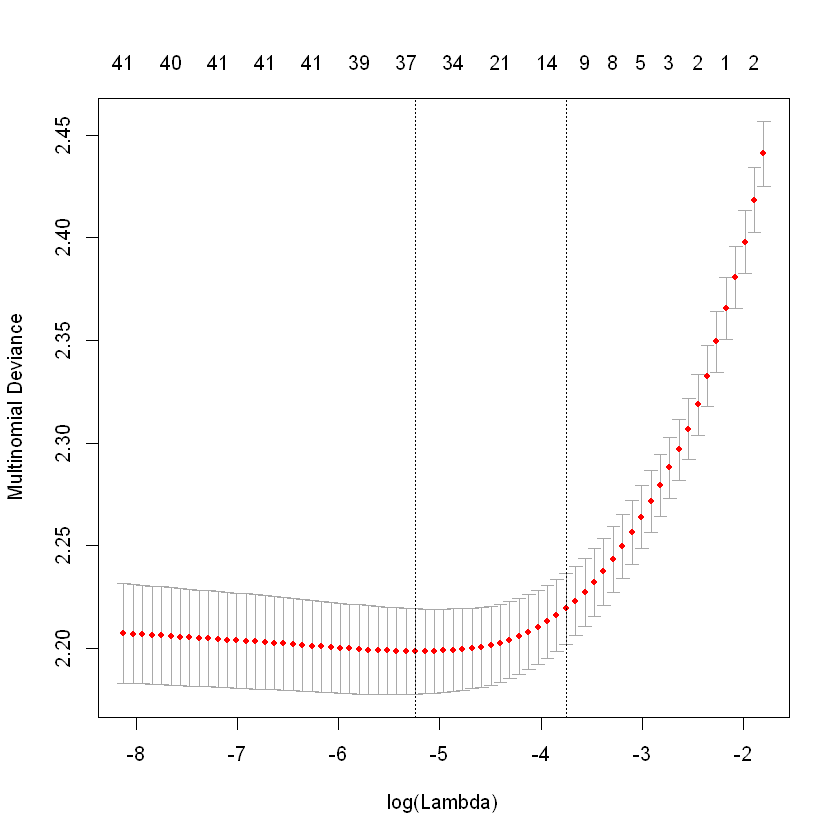

In [616]:
cv.out = cv.glmnet(x[indxTrain,],y[indxTrain],family='multinomial',type.multinomial='grouped')
plot(cv.out)

In [617]:
bestlam =cv.out$lambda.min
bestlam

[1] 0.00530548

In [618]:
lasso.pred=predict(lasso.mod,s=bestlam,newx=x[-indxTrain,],type='response')

In [619]:
mean((round(lasso.pred) -y[-indxTrain])^2)

[1] 2.530126

In [620]:
out=glmnet(x,y,lambda=grid,family='multinomial',type.multinomial='grouped')

In [621]:
coefs_fb = data.frame(coef(out,s=bestlam)$'0'[,1])
coefs_cu = data.frame(coef(out,s=bestlam)$'1'[,1])
coefs_ch = data.frame(coef(out,s=bestlam)$'2'[,1])
coefs_sl = data.frame(coef(out,s=bestlam)$'3'[,1])

In [622]:
coefs = data.frame(coefs_fb[,0],coefs_fb[,1],coefs_cu[,1],coefs_ch[,1],coefs_sl[,1])
colnames(coefs) = c("FB","CU","CH","SL")

The coefficients for each variable after it is reduced by the lasso are shown below. Not counting the intercept term, there are still 37 variables that were not reduced to zero. This is not a very exciting subset so I will try to find the best $\lambda$ value again but this time I will include a max value for the degrees of freedom I will allow the model to have. This will ensure that I have a reduced dataset of a certain size.

In [628]:
nonzero=coefs[coefs[,1:4]!=0,]
nonzero = nonzero[1:38,]
xtable(nonzero)

,FB,CU,CH,SL
(Intercept),1.210894e+00,-7.428190e-01,-8.964071e-01,4.283324e-01
prior_ball,-5.250616e-02,-3.405571e-02,1.479702e-01,-6.140831e-02
prior_foul_bunt,-1.267953e-02,-3.026692e-02,-1.385628e-02,5.680273e-02
prior_foul_tip,1.452773e-02,-9.698748e-02,-7.453442e-02,1.569942e-01
prior_hit_into_play,2.697388e-02,2.774578e-02,-1.228716e-02,-4.243250e-02
prior_hit_into_play_no_out,-8.610931e-02,-1.871126e-01,1.800075e-01,9.321435e-02
prior_hit_into_play_score,-1.558507e-01,9.797363e-02,-4.063418e-02,9.851127e-02
prior_intent_ball,-9.644840e-01,-6.282688e-01,-1.177802e-02,1.604531e+00
prior_missed_bunt,5.743291e-01,-2.819475e-01,1.881310e-01,-4.805126e-01
prior_swinging_strike,7.281957e-03,-8.933301e-03,-1.085906e-02,1.251040e-02


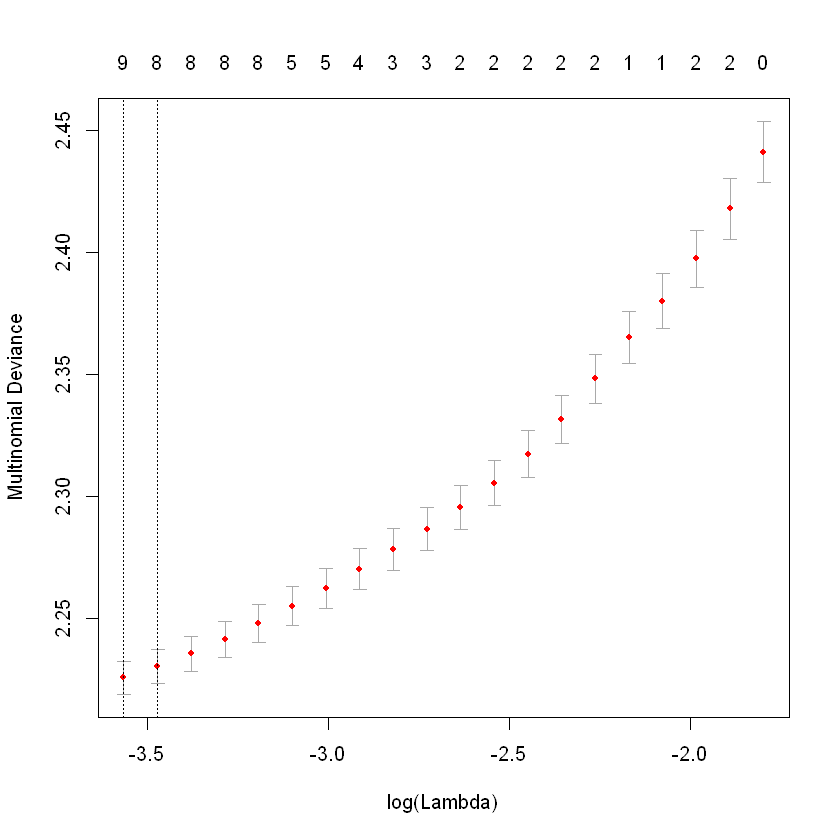

In [640]:
cv.out = cv.glmnet(x[indxTrain,],y[indxTrain],family='multinomial',type.multinomial='grouped',dfmax=10)
plot(cv.out)

In [641]:
bestlam =cv.out$lambda.min
out=glmnet(x,y,lambda=grid,family='multinomial',type.multinomial='grouped')
coefs_fb = data.frame(coef(out,s=bestlam)$'0'[,1])
coefs_cu = data.frame(coef(out,s=bestlam)$'1'[,1])
coefs_ch = data.frame(coef(out,s=bestlam)$'2'[,1])
coefs_sl = data.frame(coef(out,s=bestlam)$'3'[,1])
coefs = data.frame(coefs_fb[,0],coefs_fb[,1],coefs_cu[,1],coefs_ch[,1],coefs_sl[,1])
colnames(coefs) = c("FB","CU","CH","SL")
nonzero=coefs[coefs[,1:4]!=0,]
nonzero = nonzero[1:10,]
xtable(nonzero)

,FB,CU,CH,SL
(Intercept),1.1045899519,-7.896260e-01,-0.7098664935,0.3949025826
prior_ball,-0.0021289816,-4.249187e-03,0.0117266534,-0.0053484845
prior_hit_into_play,0.0040548387,4.334266e-03,-0.0039775130,-0.0044115922
prior_intent_ball,-0.0651731527,-2.307410e-02,-0.0066233889,0.0948706401
pk_coors,0.0264360624,-3.146744e-03,-0.0080393144,-0.0152500039
on_2b,-0.1147890918,-5.144227e-02,0.0373841867,0.1288471724
on_1b,-0.0539856519,-4.774701e-02,0.1027086429,-0.0009759781
outs_0,-0.0001761825,-2.618552e-05,0.0000574748,0.0001448932
outs_2,0.0107209622,-3.114152e-03,-0.0046266831,-0.0029801273
stand_L,-0.2483571748,3.785942e-01,1.0079665733,-1.1382035753


Now we have an interesting subset that includes variables that seem to be more worthwile than many of the original ones included. Lets see if this will effect performance of the models used above.

# Re-Test Models with Reduced Dataset

In [643]:
train_data = train[c('prior_ball','prior_hit_into_play','prior_intent_ball','pk_coors','on_2b','on_1b','outs_0','outs_2',
                     'stand_L')]
test_data = test[c('prior_ball','prior_hit_into_play','prior_intent_ball','pk_coors','on_2b','on_1b','outs_0','outs_2',
                     'stand_L')]

## LDA

There is no longer an issue of collinearity so LDA will produce meaningful results now.

Accuracy = 53% <br>
FB accuracy = 93% <br>
CU accuracy = 0% <br>
CH accuracy = 9% <br>
SL accuracy = 14%

$$ \text{test } \varepsilon = 1.93$$

There is a slight improvement in general.

In [650]:
65/(404+4+65)

[1] 0.1374207

In [666]:
(1073+218+330+404)/nrow(test)

[1] 0.9105216

In [644]:
lda_fit = lda(train_data, train$pitch)
pred.lda = predict(lda_fit, test_data)
xtable(table(pred.lda$class,test$pitch))

,0,1,2,3
0,1073,218,330,404
1,0,0,0,0
2,28,7,32,4
3,52,2,9,65


In [645]:
mean((as.numeric(pred.lda$class)-test$pitch)^2)

[1] 1.92536

In [646]:
(1073+32+65)/nrow(test)

[1] 0.5260791

## KNN

In [451]:
knn_data = pitcher[c('prior_ball','prior_hit_into_play','prior_intent_ball','pk_coors','on_2b','on_1b','outs_0','outs_2',
                     'stand_L')]

Accuracy = 51% <br>
FB accuracy = 93% <br>
CU accuracy = 0% <br>
CH accuracy = 13% <br>
SL accuracy = 10%

$$ \text{test } \varepsilon = 1.89$$

In [659]:
2.2/(18.8+2.2+0.3)

[1] 0.1032864

In [663]:
46.9+9.9+14.6+18.8

[1] 90.2

In [452]:
train_classes = as.factor(pitcher$pitch)
knnFit = train(knn_data, train_classes,method = "knn",trControl = trainControl(method = "cv"))
confusionMatrix(knnFit)

Cross-Validated (10 fold) Confusion Matrix 

(entries are percentual average cell counts across resamples)
 
          Reference
Prediction    0    1    2    3
         0 46.9  9.9 14.6 18.8
         1  0.0  0.0  0.0  0.0
         2  2.0  0.5  2.3  0.3
         3  1.8  0.3  0.3  2.2
                            
 Accuracy (average) : 0.5143


In [453]:
mean((as.numeric(predict(knnFit, test_data))-test$pitch)^2)

[1] 1.892086

## multinomial logistic regression

In [682]:
pitcher.mn = multinom(pitch~prior_ball+prior_hit_into_play+prior_intent_ball+pk_coors+outs_0+outs_2
                      +on_2b+on_1b+stand_L,data=train)

# weights:  44 (30 variable)
initial  value 9253.514860 
iter  10 value 7597.821106
iter  20 value 7504.471704
iter  30 value 7484.626699
iter  40 value 7482.138295
final  value 7482.133441 
converged


Accuracy = 53% <br>
FB accuracy = 93% <br>
CU accuracy = 0% <br>
CH accuracy = 8% <br>
SL accuracy = 13%

$$ \text{test } \varepsilon = 1.89$$

In [683]:
pitch.probs = predict(pitcher.mn,test)
xtable(table(pitch.probs,test$pitch))

,0,1,2,3
0,1078,218,330,408
1,0,0,0,0
2,28,7,32,4
3,47,2,9,61


In [690]:
(32)/(330+41)

[1] 0.08625337

In [689]:
mean((as.numeric(pitch.probs)-test$pitch)^2)

[1] 1.897032

In [677]:
60/(63+410)

[1] 0.1268499

# Conclusions

After reducing the dimensionality of the dataset the KNN,LDA, and logistic regression models performed pretty well, maintaining an overall accuracy rate of 51%,53%, and 53%, respectively. Since Greinke throws a fastball at a rate of 50.7%, this is only slightly better than just guessing that the pitch will be a fastball every time. The logistic regression model actually came to this conclusion itself and started guessing fastball everytime and did ok overall. The logistic regression model before the lasso may be the best model because it predicted sliders at a 30% accuracy rate. The dimension reduction comes in handy becuase I can confirm my claim that batter stance greatly effects slider choice. Below, i rerun the multinomial logistic regression without th stand_L variable and now the only pitch the model wants to choose is fastball. To me, this is a clear indication that there is some signal hidden beneath the giant pile of noise that is baseball statistics.

In [718]:
pitcher.mn = multinom(pitch~prior_ball+prior_hit_into_play+prior_intent_ball+pk_coors+outs_0+outs_2
                      +on_2b+on_1b,data=train)
pitch.probs = predict(pitcher.mn,test)

# weights:  40 (27 variable)
initial  value 9253.514860 
iter  10 value 8114.275356
iter  20 value 8018.411830
iter  30 value 8003.243848
iter  40 value 8003.174389
final  value 8003.173814 
converged


In [719]:
xtable(table(pitch.probs,test$pitch))

,0,1,2,3
0,1153,227,371,470
1,0,0,0,0
2,0,0,0,0
3,0,0,0,3
